# Improving vector space using retrofitting


In [65]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-

In [1]:
# Standard library imports
import argparse
import gzip
import math
import re
import sys
import urllib.request
import io
import random
from copy import deepcopy

# Third-party library imports
import numpy as np
import pandas as pd
import gensim
import gensim.downloader as api
from gensim import corpora, matutils
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import wordnet
from sklearn.cluster import KMeans

## 1. Implement the retrofitting algorithm proposed by Faruqui et al. on a lexicon of distributional vector representations of words

In [2]:
''' Getting the pretrained word embeddings '''
print(gensim.__file__)

# available pre-trained models
# gensim.downloader.info()

# load pre-trained Word2Vec model
model = api.load('word2vec-google-news-300')

# download the pre-trained word2vec model
# path = api.load('word2vec-google-news-300', return_path=True)
# print(path)

C:\Users\ninan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gensim\__init__.py


### 1.1 Data preprocessing 

In [3]:
# From Faruqi
isNumber = re.compile(r'\d+.*')

def norm_word(word):
  """
  - input: word
  - return: a normalized version of it
  Normalization process: includes checking if the word is a number or a punctuation mark and replacing it with special tokens
  """
  if isNumber.search(word.lower()):
    return '---num---'
  # check if the word consists only of non-alphanumeric characters by removing all non-alphanumeric characters from the word 
  # and checking if the result is an empty string
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
  # if input word not a number nor a punctuation mark, return a lowercase version of input word
    return word.lower()
  

  
''' Read all the word vectors and normalize them '''
def read_word_vecs(filename):
  """
  - input: name of the file containing the word vectors
  """
  wordVectors = {}
  with open(filename, 'r', encoding='utf-8') as fileObject:
    for line in fileObject:
      line = line.strip().lower()
      # The first word is assumed to be the word itself, and the remaining words are assumed to be the components of the word vector
      word = line.split()[0]
      # initialize a numpy array of zeros with the same length as the word vector
      wordVectors[word] = np.zeros(len(line.split())-1, dtype=float)
      for index, vecVal in enumerate(line.split()[1:]):
        # assign the values in the numpy array to the corresponding components of the word vector
        wordVectors[word][index] = float(vecVal)
      ''' normalize weight vector '''
      # divide each element by the square root of the sum of the squares of all the elements in the array
      # plus a small constant (1e-6) to avoid division by zero
      wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
  
  # standard error indicating that the vectors have been read from the file 
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

''' Write word vectors to file '''
def print_word_vecs(wordVectors, outFileName):
  """
  - input: a dictionary wordVectors where keys are words and values are their corresponding word vectors
           file name outFileName
  """
  sys.stderr.write('\nWriting down the vectors in '+outFileName+'\n')
  outFile = open(outFileName, 'w', encoding= 'utf-8')  
  for word, values in wordVectors.items():
    outFile.write(word+' ')
    for val in wordVectors[word]:
      # write the word vectors to the ouptut file in the format:
      # word1 val1 val2 val3 ...
      # word2 val1 val2 val3 ...
      # ...
      outFile.write('%.4f' %(val)+' ')
    outFile.write('\n')      
  outFile.close()

''' Read the PPDB word relations as a dictionary '''
def read_lexicon(filename):
    lexicon = {}
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            words = line.lower().strip().split()
            lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]
    return lexicon

In [46]:
def convert_dict_to_matrix1(wordVecs):
    words = list(wordVecs.keys())
    wordVecMat = np.array(list(wordVecs.values()))

    return wordVecMat

def convert_dict_to_matrix(wordVecs):
    words = list(wordVecs.keys())
    wordVecMat = np.array(list(wordVecs.values()))

    # Reshape the matrix if it is one-dimensional
    if wordVecMat.ndim == 1:
        wordVecMat = wordVecMat.reshape(1, -1)

    return wordVecMat

def convert_matrix_to_dict1(wordVecMat, wordVecs):
    updatedWordVecs = {}

    for i, word in enumerate(wordVecs.keys()):
        updatedWordVecs[word] = wordVecMat[i]

    return updatedWordVecs

def convert_matrix_to_dict2(wordVecMat, wordVecs):
    updated_wordVecs = {word: vec for word, vec in zip(wordVecs.keys(), wordVecMat)}

    return updated_wordVecs

def vectorize_list(corpus):
    corpus_vecs = [model[word] for word in corpus]

    return corpus_vecs

In [47]:
toy_corpus = ["cat", "dog", "caramel", "cheese", "chocolate", "cacao", "right", "left"]
toy_dict_corpus = {"random1": [0.2, 0.4, 0.1], "random2": [0.5, 0.7, 0.3], "random3": [0.8, 0.6, 0.2], "random3": [0.3, 0.7, 0.2], "random4": [0.1, 0.3, 0.1], "random5": [0.4, 0.6, 0.2], "random6": [0.1, 0.3, 0.4], "random7": [0.6, 0.9, 0.2]}

In [48]:
toy_dict_vecs= convert_dict_to_matrix(toy_dict_corpus)
convert_matrix_to_dict2(toy_dict_vecs, toy_dict_corpus)

{'random1': array([0.2, 0.4, 0.1]),
 'random2': array([0.5, 0.7, 0.3]),
 'random3': array([0.3, 0.7, 0.2]),
 'random4': array([0.1, 0.3, 0.1]),
 'random5': array([0.4, 0.6, 0.2]),
 'random6': array([0.1, 0.3, 0.4]),
 'random7': array([0.6, 0.9, 0.2])}

In [49]:
toy_corpus_vecs = vectorize_list(toy_corpus)
toy_corpus_vecs

[array([ 0.0123291 ,  0.20410156, -0.28515625,  0.21679688,  0.11816406,
         0.08300781,  0.04980469, -0.00952148,  0.22070312, -0.12597656,
         0.08056641, -0.5859375 , -0.00445557, -0.296875  , -0.01312256,
        -0.08349609,  0.05053711,  0.15136719, -0.44921875, -0.0135498 ,
         0.21484375, -0.14746094,  0.22460938, -0.125     , -0.09716797,
         0.24902344, -0.2890625 ,  0.36523438,  0.41210938, -0.0859375 ,
        -0.07861328, -0.19726562, -0.09082031, -0.14160156, -0.10253906,
         0.13085938, -0.00346375,  0.07226562,  0.04418945,  0.34570312,
         0.07470703, -0.11230469,  0.06738281,  0.11230469,  0.01977539,
        -0.12353516,  0.20996094, -0.07226562, -0.02783203,  0.05541992,
        -0.33398438,  0.08544922,  0.34375   ,  0.13964844,  0.04931641,
        -0.13476562,  0.16308594, -0.37304688,  0.39648438,  0.10693359,
         0.22167969,  0.21289062, -0.08984375,  0.20703125,  0.08935547,
        -0.08251953,  0.05957031,  0.10205078, -0.1

In [50]:
# Extract the unique words from the dictionary keys
toy_dict_words = list(toy_dict_corpus.keys())

# Determine the length of the word vectors
toy_dict_vector_length = len(next(iter(toy_dict_corpus.values())))

# Create an empty matrix with the shape (number of words, vector length)
toy_corpus_vecs_matrix = np.zeros((len(toy_dict_words), toy_dict_vector_length))

# Populate the word vectors matrix
for idx, word in enumerate(toy_dict_words):
    toy_corpus_vecs_matrix[idx] = toy_dict_corpus[word]

print(toy_corpus_vecs_matrix)

[[0.2 0.4 0.1]
 [0.5 0.7 0.3]
 [0.3 0.7 0.2]
 [0.1 0.3 0.1]
 [0.4 0.6 0.2]
 [0.1 0.3 0.4]
 [0.6 0.9 0.2]]


### 1.2 Data

In [51]:
''' Retrieving all the necessary data'''
# word embeddings
wordVecs = read_word_vecs("../data/English/wordEmbeddings/vectors_datatxt_250_sg_w10_i5_c500_gensim_clean")
# semantic relations
lexical_similarity = read_lexicon("../data/English/lexicon/ws353_lexical_similarity.txt")
ppdb_lexicon = read_lexicon('../data/English/lexicon/ppdb-xl.txt')
wordnet_lexicon = read_lexicon('../data/English/lexicon/wordnet-synonyms+.txt')
# the file for the updated embeddings
output_file = "../data/English/output_vectors/output_vectors.txt"
outFileName = output_file

Vectors read from: ../data/English/wordEmbeddings/vectors_datatxt_250_sg_w10_i5_c500_gensim_clean 


In [ ]:
ppdb_lexicon

In [52]:
# Retrieve semantic relations from WordNet
def get_wordnet_for_specific_relation(word, relation_type):
    relations = []
    synsets = wordnet.synsets(word)
    for synset in synsets:
        if relation_type == "synonyms":
            synonyms = synset.lemmas()
            synonyms = [lemma.name() for lemma in synonyms]
            relations.extend(synonyms)
        elif relation_type == "hypernyms":
            hypernyms = synset.hypernyms()
            hypernyms = [hypernym.name().split('.')[0] for hypernym in hypernyms]
            relations.extend(hypernyms)
        elif relation_type == "hyponyms":
            hyponyms = synset.hyponyms()
            hyponyms = [hyponym.name().split('.')[0] for hyponym in hyponyms]
            relations.extend(hyponyms)
        elif relation_type == "meronyms":
            meronyms = synset.part_meronyms()
            meronyms = [meronym.name().split('.')[0] for meronym in meronyms]
            relations.extend(meronyms)
    return relations

def get_wordnet_relations(word):
    relations = []
    synsets = wordnet.synsets(word)
    for synset in synsets:
        # Retrieve synonyms, hypernyms, hyponyms, or other related words based on your desired impact
        relations.extend([lemma.name() for lemma in synset.lemmas()])
        relations.extend([hypernym.lemma_names()[0] for hypernym in synset.hypernyms()])
        relations.extend([hyponym.lemma_names()[0] for hyponym in synset.hyponyms()])
    
    return relations

# Example usage to retrieve synonyms, hypernyms, and hyponyms for a word
word = "example"
synonyms = get_wordnet_for_specific_relation(word, "synonyms")
hypernyms = get_wordnet_for_specific_relation(word, "hypernyms")
hyponyms = get_wordnet_for_specific_relation(word, "hyponyms")

wordnet_lexicon1 = {}
for word in wordVecs:
    wordnet_relations = get_wordnet_relations(word)
    wordnet_lexicon[word] = wordnet_relations

In [54]:
wordVecs_matrix = convert_dict_to_matrix(wordVecs)

C:\Users\ninan\AppData\Local\Temp\ipykernel_12916\755764730.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wordVecMat = np.array(list(wordVecs.values()))


In [56]:
#function for creating a semantic lexicon dictionary 
def get_wordnet_lexicon(target_words, synonyms=True, antonyms=True, hyponyms=True, hypernyms=True, meronyms=True, holonyms=True, homonyms=True):
    #dictionary to store the related words for each target word
    #keys = target words
    #values = list related words
    lexicon = {}

    #Use WordNet to find related words through various semantic relations for each target word
    #loop over the target words
    for word in target_words:
        #initialise empty related_words list which will hold 
        #all the semantically related words extracted from WordNet
        related_words = []
        #iterate through each synset (set of synonyms)
        
        for syn in wordnet.synsets(word):
            #iterate thorugh each lemma (individual word) for the synset and append to related_words
            for lemma in syn.lemmas():
                if lemma.name() != word:
                    #if you want to extract synonyms
                    if synonyms:
                        related_words.append(lemma.name())

            if antonyms:           
                #check antonym for first lemma of the synset and append
                if syn.lemmas()[0].antonyms():
                    related_words.append(syn.lemmas()[0].antonyms()[0].name())
            
            #if you want to extract hyponyms
            if hyponyms:
                #check for hyponym and append
                for hypo in syn.hyponyms():
                    for lemma in hypo.lemmas():
                        related_words.append(lemma.name())

            #if you want to extract hypernyms
            if hypernyms:            
                #check for hypernym and append
                for hyper in syn.hypernyms():
                    for lemma in hyper.lemmas():
                        related_words.append(lemma.name())

            #if you want to extract meronyms
            if meronyms:             
                #check for meronym and append
                for part in syn.part_meronyms():
                    for lemma in part.lemmas():
                        related_words.append(lemma.name())

            #if you want to extract hypernyms
            if holonyms:             
                #check for holonym and append
                for whole in syn.part_holonyms():
                    for lemma in whole.lemmas(): 
                        related_words.append(lemma.name())

            #if you want to extract homonyms
            if homonyms:             
                #iterate through each lemma for the current synset
                #for each lemma not the same as target word
                #find all lemmas that have same spelling and append
                for lemma in syn.lemmas():
                    if lemma.name() != word:
                        homonyms = wordnet.lemmas(lemma.name())
                        for homonym in homonyms:
                            related_words.append(homonym.name())
        lexicon[word] = related_words
    return lexicon

### 1.3 Measure the cosine similarity before retrofitting

In [57]:
''' Get vectors cosine similarity before retrofitting '''
def calculate_cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm1 * norm2)
    return similarity

def calculate_cosine_similarity_matrix(vectors):
    num_vectors = len(vectors)
    similarity_matrix = np.zeros((num_vectors, num_vectors))

    for i in range(num_vectors):
        for j in range(num_vectors):
            similarity = calculate_cosine_similarity(vectors[i], vectors[j])
            similarity_matrix[i, j] = similarity

    return similarity_matrix

# Cosine similarity from word2vec
def print_similarities(corpus):
    for i, word1 in enumerate(corpus):
        print(f'Similarities with "{word1}":')
        for j, word2 in enumerate(corpus):
            if i == j:
                continue
            similarity = model.similarity(word1, word2) # TODO: comment ça fonctionne?
            print(f'  - "{word2}": {similarity:.4f}')
        print()

def print_vec_similarities(corpus, vectorized_corpus) :
    for i, vec1 in enumerate(vectorized_corpus):
        word1 = corpus[i]
        print(f'Similarities with "{word1}":')
        for j, vec2 in enumerate(vectorized_corpus):
            if i == j:
                continue
            similarity = calculate_cosine_similarity(vec1, vec2)
            print(f'  - "{corpus[j]}": {similarity:.4f}')
        print()

def print_matrix_similarities(similarity_matrix, word_index, words):
    word = words[word_index]
    similarities = similarity_matrix[word_index]
    print(f"Similarities with \"{word}\":")
    for idx, similarity in enumerate(similarities):
        if idx != word_index:
            print(f"  - \"{words[idx]}\": {similarity:.4f}")

In [58]:
print_similarities(toy_corpus)

Similarities with "cat":
  - "dog": 0.7609
  - "caramel": 0.1662
  - "cheese": 0.1403
  - "chocolate": 0.2410
  - "cacao": 0.0969
  - "right": 0.0848
  - "left": 0.1096

Similarities with "dog":
  - "cat": 0.7609
  - "caramel": 0.1551
  - "cheese": 0.1794
  - "chocolate": 0.3049
  - "cacao": 0.0794
  - "right": 0.1091
  - "left": 0.0765

Similarities with "caramel":
  - "cat": 0.1662
  - "dog": 0.1551
  - "cheese": 0.4823
  - "chocolate": 0.6732
  - "cacao": 0.3757
  - "right": 0.0651
  - "left": 0.0714

Similarities with "cheese":
  - "cat": 0.1403
  - "dog": 0.1794
  - "caramel": 0.4823
  - "chocolate": 0.6063
  - "cacao": 0.3334
  - "right": 0.0771
  - "left": 0.0789

Similarities with "chocolate":
  - "cat": 0.2410
  - "dog": 0.3049
  - "caramel": 0.6732
  - "cheese": 0.6063
  - "cacao": 0.5436
  - "right": 0.0389
  - "left": 0.0513

Similarities with "cacao":
  - "cat": 0.0969
  - "dog": 0.0794
  - "caramel": 0.3757
  - "cheese": 0.3334
  - "chocolate": 0.5436
  - "right": 0.0284


In [59]:
print_vec_similarities(toy_corpus, toy_corpus_vecs)

Similarities with "cat":
  - "dog": 0.7609
  - "caramel": 0.1662
  - "cheese": 0.1403
  - "chocolate": 0.2410
  - "cacao": 0.0969
  - "right": 0.0848
  - "left": 0.1096

Similarities with "dog":
  - "cat": 0.7609
  - "caramel": 0.1551
  - "cheese": 0.1794
  - "chocolate": 0.3049
  - "cacao": 0.0794
  - "right": 0.1091
  - "left": 0.0765

Similarities with "caramel":
  - "cat": 0.1662
  - "dog": 0.1551
  - "cheese": 0.4823
  - "chocolate": 0.6732
  - "cacao": 0.3757
  - "right": 0.0651
  - "left": 0.0714

Similarities with "cheese":
  - "cat": 0.1403
  - "dog": 0.1794
  - "caramel": 0.4823
  - "chocolate": 0.6063
  - "cacao": 0.3334
  - "right": 0.0771
  - "left": 0.0789

Similarities with "chocolate":
  - "cat": 0.2410
  - "dog": 0.3049
  - "caramel": 0.6732
  - "cheese": 0.6063
  - "cacao": 0.5436
  - "right": 0.0389
  - "left": 0.0513

Similarities with "cacao":
  - "cat": 0.0969
  - "dog": 0.0794
  - "caramel": 0.3757
  - "cheese": 0.3334
  - "chocolate": 0.5436
  - "right": 0.0284


In [60]:
toy_dict_vecs_matrix = np.array(list(toy_dict_corpus.values()))

toy_dict_similarity_matrix = calculate_cosine_similarity_matrix(toy_dict_vecs_matrix)

toy_dict_word_index = toy_dict_words.index("random1")
print_matrix_similarities(toy_dict_similarity_matrix, toy_dict_word_index, toy_dict_words)

Similarities with "random1":
  - "random2": 0.9821
  - "random3": 0.9977
  - "random4": 0.9869
  - "random5": 0.9915
  - "random6": 0.7703
  - "random7": 0.9919


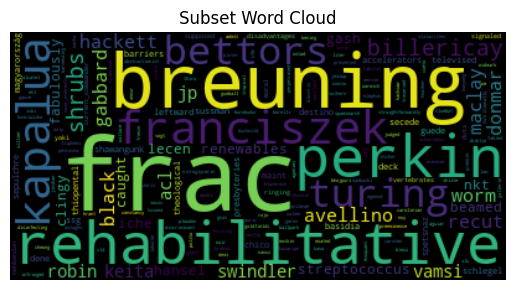

In [61]:
''' Checking the similarity between word embeddings'''
# 1) Sampling
# Set the size of the subset you want to sample
subset_size = 500

# Randomly select a subset of vectors
subset_words = random.sample(list(wordVecs.keys()), subset_size)
subset_vectors = [wordVecs[word] for word in subset_words]

# Calculate the pairwise cosine similarities for the subset
subset_similarity_matrix = cosine_similarity(subset_vectors)

# Create a word cloud for the subset
subset_wordcloud = WordCloud().generate(' '.join(subset_words))

# Plot the word cloud
plt.imshow(subset_wordcloud, interpolation='bilinear')
plt.title('Subset Word Cloud')
plt.axis('off')
plt.show()


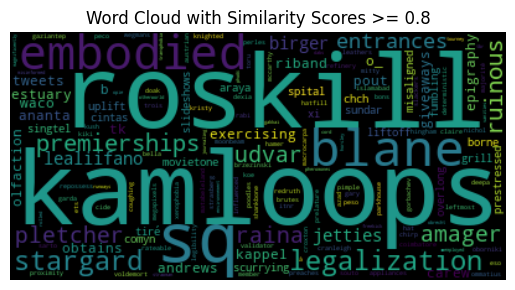

In [62]:
# Set the size of the subset you want to sample
subset_size = 500

# Randomly select a subset of vectors
subset_words = random.sample(list(wordVecs.keys()), subset_size)
subset_vectors = [wordVecs[word] for word in subset_words]

# Calculate the pairwise cosine similarities for the subset
subset_similarity_matrix = calculate_cosine_similarity_matrix(subset_vectors)

# Create a word cloud for the subset with similarity scores >= 0.8
wordcloud_words = [word for i, word in enumerate(subset_words) if np.any(subset_similarity_matrix[i] >= 0.8)]
wordcloud = WordCloud().generate(' '.join(wordcloud_words))

# Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud with Similarity Scores >= 0.8')
plt.axis('off')
plt.show()

In [63]:
# 2) Clustering

# Get the length of the first word vector
vector_length = len(next(iter(wordVecs.values())))

# Filter out word vectors with different lengths
filtered_wordVecs = {word: vector for word, vector in wordVecs.items() if len(vector) == vector_length}

# Check if the number of word vectors is sufficient for clustering
num_vectors = len(filtered_wordVecs)
num_clusters = 3  # Specify the desired number of clusters

if num_vectors >= num_clusters:
    # Perform clustering with K-means
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(list(filtered_wordVecs.values()))

    # Get the cluster labels for each word
    labels = kmeans.labels_

    # Create a dictionary to store the cluster assignments
    clusters = {}
    for i, word in enumerate(filtered_wordVecs.keys()):
        cluster_id = labels[i]
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(word)

    # Print the words in each cluster
    for cluster_id, words in clusters.items():
        print(f"Cluster {cluster_id}:")
        print(words)
        print()
else:
    print("Insufficient number of word vectors for clustering.")

Insufficient number of word vectors for clustering.


In [64]:
# # 3) Word clouds
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# # Calculate the cosine similarity matrix and retrive a list of words
# words = list(wordVecs.keys())
# word_vecs_matrix = np.array(list(wordVecs.values()))
# vecs_similarity_matrix = calculate_cosine_similarity_matrix(word_vecs_matrix)

# # Set the similarity threshold
# threshold = 0.5

# # Create lists for high similarity words and low similarity words
# high_similarity_words = []
# low_similarity_words = []

# # Classify words based on similarity threshold
# for i in range(len(words)):
#     for j in range(i+1, len(words)):
#         similarity = vecs_similarity_matrix[i][j]
#         if similarity >= threshold:
#             high_similarity_words.append(words[i])
#             high_similarity_words.append(words[j])
#         else:
#             low_similarity_words.append(words[i])
#             low_similarity_words.append(words[j])

# # Create word clouds for high similarity words
# high_similarity_wordcloud = WordCloud().generate(' '.join(high_similarity_words))

# # Create word clouds for low similarity words
# low_similarity_wordcloud = WordCloud().generate(' '.join(low_similarity_words))

# # Plot the word clouds
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# axs[0].imshow(high_similarity_wordcloud, interpolation='bilinear')
# axs[0].set_title('High Similarity Words')

# axs[1].imshow(low_similarity_wordcloud, interpolation='bilinear')
# axs[1].set_title('Low Similarity Words')

# # Remove axis labels
# for ax in axs:
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

In [65]:
# 4) Only considering the words in the lexicon similarity file
# Retrive words from the lexical similarity file

def print_lexical_similarities(wordVecs, lines):
    # Create a list to store the words
    word_list = []

    # Iterate over the lines and extract the words
    for line in lines:
        words = line.strip().split('\t')
        word1 = words[0]
        word2 = words[1]
        word_list.append((word1, word2))  # Store the words as a tuple

    # Determine the subset of words present in the wordVecs file while preserving the order
    subset = [word for word in word_list if word[0] in wordVecs and word[1] in wordVecs]

    # Create a dictionary to map words to indices
    w2i = {word: index for index, word in enumerate(wordVecs)}

    # Create an empty list to store the similarities
    similarities = []

    # Iterate over each tuple in the subset
    for word1, word2 in subset:
        if word1 in wordVecs and word2 in wordVecs:
            # Retrieve the embeddings for the words
            embedding1 = wordVecs[word1]
            embedding2 = wordVecs[word2]

            # Calculate the similarity between the embeddings
            similarity_score = cosine_similarity([embedding1], [embedding2])

            # Append the similarity value to the list of similarities
            similarities.append(similarity_score)

    # Print the similarities
    for i, similarity_score in enumerate(similarities):
        print(f"Similarity between {subset[i][0]} and {subset[i][1]}: {similarity_score[0][0]}")


with open('../data/English/lexicon/ws353_lexical_similarity.txt', 'r') as file:
    lines = file.readlines()

print_lexical_similarities(wordVecs, lines)

Similarity between love and sex: 0.3213976283166737
Similarity between tiger and cat: 0.4484269447717373
Similarity between tiger and tiger: 1.0
Similarity between book and paper: 0.5720403096134581
Similarity between computer and keyboard: 0.4902811841797181
Similarity between computer and internet: 0.49881600720718505
Similarity between plane and car: 0.4094837589536879
Similarity between train and car: 0.5024532628135742
Similarity between telephone and communication: 0.36768667290283835
Similarity between television and radio: 0.6536351915117727
Similarity between media and radio: 0.3209847572779895
Similarity between drug and abuse: 0.42865908078081993
Similarity between bread and butter: 0.8071053286387004
Similarity between cucumber and potato: 0.6915610413305441
Similarity between doctor and nurse: 0.5676552249319599
Similarity between professor and doctor: 0.5076438957646101
Similarity between student and professor: 0.45578493020098115
Similarity between smart and student: 0.2

In [83]:
def get_lexical_similarities(wordVecs, lines, subset):
    similarities = []

    for word1, word2 in subset:
        if word1 in wordVecs and word2 in wordVecs:
            embedding1 = wordVecs[word1]
            embedding2 = wordVecs[word2]

            similarity_score = cosine_similarity([embedding1], [embedding2])

            similarities.append((word1, word2, similarity_score[0][0]))

    return similarities


with open('../data/English/lexicon/ws353_lexical_similarity.txt', 'r') as file:
    lines = file.readlines()

word_list = []
for line in lines:
    words = line.strip().split('\t')
    word1 = words[0]
    word2 = words[1]
    word_list.append((word1, word2))

subset = [(word1, word2) for word1, word2 in word_list if word1 in wordVecs and word2 in wordVecs]

similarities = get_lexical_similarities(wordVecs, lines, subset)

for word1, word2, similarity_score in similarities:
    print(f"Similarity between {word1} and {word2}: {similarity_score}")


In [66]:
# TODO: get similaritiesof wordVecs before retrofitting
# print("Similarities before retrofitting:")
# # Check the length of the word vectors
# vector_length = len(next(iter(wordVecs.values())))

# # Create a matrix to store the word vectors
# word_vecs_matrix = np.zeros((len(wordVecs), vector_length))

# # Populate the word vectors matrix
# for idx, word in enumerate(wordVecs):
#     word_vecs_matrix[idx] = wordVecs[word]

# # Calculate the cosine similarities
# similarities = cosine_similarity(word_vecs_matrix)

# # Get the index of the word "cat" in the word embeddings
# cat_index = list(wordVecs.keys()).index("cat")

# # Get the similarity scores of the word "cat" with other words
# cat_similarities = similarities[cat_index]

# # Print the similarity scores
# for word, similarity in zip(wordVecs.keys(), cat_similarities):
#     print(f"Similarity between 'cat' and '{word}': {similarity}")

### 1.4 Retrofitting 


    Update the retrofitting algorithm:
        Consider the specific nature of the relations and the desired impact on the word embeddings. For example, synonyms may require similar adjustments, while hypernyms or hyponyms may require different weighting.

    Enhance the word vectors:
        Calculate the new vector for each word by incorporating the retrieved semantic relations into the retrofitting process.
        Adjust the weights (ALPHA and BETA) accordingly to balance the influence of the original word vector and the retrieved relations.
        Normalize the new vector to ensure it retains the desired characteristics of a word vector.

    Convert the updated matrix back to a dictionary:
        Convert the matrix of word vectors (wordVecMat) back into a dictionary format, similar to the initial word vectors (wordVecs).
        Map each word to its corresponding updated vector.

In [67]:
# Hyperparameters
ALPHA = 1 #coefficient minimizing the euclidean distance
NB_ITER = 10

# TODO: reduce beta value like 0.1/nb_neighbors
# TODO: define a stopping criterion based on changes in the Eucledean distance between adjacent vertices (eg: a threshold o less than 10^-2 as mentionned in the paper)
# TODO: test algo with French word embeddings and WOLF, since the retrofitting algo performs significantly better with French resources. If the issue persists witht he  French data, further debugging may be required

In [68]:
''' Working version but no matrix involved'''
''' Retrofit word vectors to a lexicon '''
def retrofit(wordVecs, lexicon):
  newWordVecs = deepcopy(wordVecs)
  wvVocab = set(newWordVecs.keys())
  loopVocab = wvVocab.intersection(set(lexicon.keys()))
  for _ in range(NB_ITER):
    # loop through every node also in ontology (else just use data estimate)
    for word in loopVocab:
      wordNeighbours = set(lexicon[word]).intersection(wvVocab)
      numNeighbours = len(wordNeighbours)
      #no neighbours, pass - use data estimate
      if numNeighbours == 0:
        continue
      # the weight of the data estimate if the number of neighbours
      newVec = ALPHA * wordVecs[word] + BETA * sum(newWordVecs[ppWord] for ppWord in wordNeighbours) 
      newWordVecs[word] = newVec/ (ALPHA + BETA * numNeighbours)
  return newWordVecs


In [69]:
print("Vectors before retrofitting:")
print(toy_corpus_vecs)

print("\nVectors after retrofitting")
retrofit(toy_dict_corpus, ppdb_lexicon)

Vectors before retrofitting:
[array([ 0.0123291 ,  0.20410156, -0.28515625,  0.21679688,  0.11816406,
        0.08300781,  0.04980469, -0.00952148,  0.22070312, -0.12597656,
        0.08056641, -0.5859375 , -0.00445557, -0.296875  , -0.01312256,
       -0.08349609,  0.05053711,  0.15136719, -0.44921875, -0.0135498 ,
        0.21484375, -0.14746094,  0.22460938, -0.125     , -0.09716797,
        0.24902344, -0.2890625 ,  0.36523438,  0.41210938, -0.0859375 ,
       -0.07861328, -0.19726562, -0.09082031, -0.14160156, -0.10253906,
        0.13085938, -0.00346375,  0.07226562,  0.04418945,  0.34570312,
        0.07470703, -0.11230469,  0.06738281,  0.11230469,  0.01977539,
       -0.12353516,  0.20996094, -0.07226562, -0.02783203,  0.05541992,
       -0.33398438,  0.08544922,  0.34375   ,  0.13964844,  0.04931641,
       -0.13476562,  0.16308594, -0.37304688,  0.39648438,  0.10693359,
        0.22167969,  0.21289062, -0.08984375,  0.20703125,  0.08935547,
       -0.08251953,  0.05957031,  

{'random1': [0.2, 0.4, 0.1],
 'random2': [0.5, 0.7, 0.3],
 'random3': [0.3, 0.7, 0.2],
 'random4': [0.1, 0.3, 0.1],
 'random5': [0.4, 0.6, 0.2],
 'random6': [0.1, 0.3, 0.4],
 'random7': [0.6, 0.9, 0.2]}

In [70]:
''' Retrofit word vectors to a lexicon using matrix operations and the file lexical similarity'''
def retrofit_matrix_lexical_similarity(wordVecs, lexicon):
    # Convert the word vectors dictionary to a matrix
    wordVecMat = np.array(list(wordVecs.values()))
    
    # Create a set of vocabulary indices based on the shape of wordVecMat
    wvVocab = set(range(wordVecMat.shape[0]))
    
    # Find the common vocabulary between wordVecMat and the lexicon
    loopVocab = wvVocab.intersection(set(lexicon.keys()))
    
    # Iterate over the specified number of iterations
    for _ in range(NB_ITER):
        for word in loopVocab:
            wordNeighbours = set(lexicon[word]).intersection(wvVocab)
            numNeighbours = len(wordNeighbours)
            
            if numNeighbours == 0:
                continue
            
            newVec = ALPHA * wordVecMat[word] + BETA * np.sum(wordVecMat[list(wordNeighbours)], axis=0)
            newWordVec = newVec / (ALPHA + BETA * numNeighbours)
            
            wordVecMat[word] = newWordVec
    
    # Convert the matrix back to a dictionary of word vectors
    newWordVecs = {word: vec for word, vec in zip(wordVecs.keys(), wordVecMat)}
    
    return newWordVecs

In [71]:
# Apply retrofitting using matrix operations
retrofittedVecMat = retrofit_matrix_lexical_similarity(wordVecs, lexical_similarity)

# Convert the retrofitted matrix back to a dictionary of word vectors
retrofittedVecs = {}
for word, vec in zip(wordVecs.keys(), retrofittedVecMat):
    retrofittedVecs[word] = vec

# Save the retrofitted vectors to an output file
with open(output_file, 'w', encoding='utf-8') as outputFile:
    for word, vec in retrofittedVecs.items():
        outputFile.write(word + ' ' + ' '.join(str(val) for val in vec) + '\n')

C:\Users\ninan\AppData\Local\Temp\ipykernel_12916\3058565280.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wordVecMat = np.array(list(wordVecs.values()))


In [72]:
  # norm = np.linalg.norm(newWordVecs[word])
  #   if norm > 0:
  #       newWordVecs[word] /= norm

def normalize_vectors(wordVecMat):
    # Calculate the Euclidean norms of the vectors
    norms = np.linalg.norm(wordVecMat, axis=1, keepdims=True)

    # Divide each vector by its corresponding norm to normalize them
    normalized_wordVecMat = wordVecMat / norms

    return normalized_wordVecMat

In [73]:
def retrofit_embeddings_diverse_semantic_relations(wordVecs, ppdb_lexicon, wordnet_lexicon, normalizing=True):
    # Convert the word vectors dictionary to a matrix
    wordVecMat = convert_dict_to_matrix(wordVecs) #TODO: or use np.array(list(wordVecs.values())) # wordVecMat = np.array(list(wordVecs.values()), dtype=object)
    print("Original shape of wordVecMat:", wordVecMat.shape)

    # Print the lengths of the word vectors
    lengths = [len(vec) for vec in wordVecMat]
    print("Lengths of word vectors:", lengths)
    
    # Create a set of vocabulary indices based on the shape of wordVecMat
    wvVocab = set(range(wordVecMat.shape[0]))

    # Find the common vocabulary between wordVecMat and the lexicons
    loopVocab = wvVocab.intersection(set(ppdb_lexicon.keys())).intersection(set(wordnet_lexicon.keys()))

    # Iterate over the specified number of iterations
    for _ in range(NB_ITER):
        for word in loopVocab:
            wordNeighbours = set(ppdb_lexicon[word]).union(set(wordnet_lexicon[word]))
            numNeighbours = len(wordNeighbours)

            # Retrieve semantic relations from PPDB and WordNet
            ppdb_relations = ppdb_lexicon.get(word, [])
            wordnet_relations = wordnet_lexicon.get(word, [])

            # Combine the relations with the existing lexicon
            combined_relations = list(wordNeighbours) + ppdb_relations + wordnet_relations

            BETA = 1/ len(combined_relations) # minimizes each vector distance to ? 

            if numNeighbours == 0:
                continue

            newVec = ALPHA * wordVecMat[word] + BETA * np.sum(wordVecMat[list(combined_relations)], axis=0)
            newWordVec = newVec / (ALPHA + BETA * numNeighbours)

            wordVecMat[word] = newWordVec
    print("Shape of wordVecMat after retrofitting:", wordVecMat.shape)

    # Normalize the word vectors
    if normalizing:
        wordVecMat = normalize_vectors(wordVecMat)
    print("Shape of wordVecMat after normalization:", wordVecMat.shape)
    
    # Convert the matrix back to a dictionary of word vectors
    newWordVecs = {word: vec for word, vec in zip(wordVecs.keys(), wordVecMat)}
    
    return newWordVecs


In [74]:
# Retrofit the word embeddings
updatedWordVecs = retrofit_embeddings_diverse_semantic_relations(wordVecs, ppdb_lexicon, wordnet_lexicon, normalizing=False)

# # Print the updated word embeddings
# for word, vec in updatedWordVecs.items():
#     print(f"{word}: {vec}")
# Save the retrofitted vectors to an output file
with open(output_file, 'w', encoding='utf-8') as outputFile:
    for word, vec in updatedWordVecs.items():
        outputFile.write(word + ' ' + ' '.join(str(val) for val in vec) + '\n')

C:\Users\ninan\AppData\Local\Temp\ipykernel_12916\755764730.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wordVecMat = np.array(list(wordVecs.values()))


Original shape of wordVecMat: (1, 125777)
Lengths of word vectors: [125777]
Shape of wordVecMat after retrofitting: (1, 125777)
Shape of wordVecMat after normalization: (1, 125777)


In [75]:
print('Vectors before retrofitting')
print_lexical_similarities(wordVecs, lines)

Vectors before retrofitting
Similarity between love and sex: 0.3213976283166737
Similarity between tiger and cat: 0.4484269447717373
Similarity between tiger and tiger: 1.0
Similarity between book and paper: 0.5720403096134581
Similarity between computer and keyboard: 0.4902811841797181
Similarity between computer and internet: 0.49881600720718505
Similarity between plane and car: 0.4094837589536879
Similarity between train and car: 0.5024532628135742
Similarity between telephone and communication: 0.36768667290283835
Similarity between television and radio: 0.6536351915117727
Similarity between media and radio: 0.3209847572779895
Similarity between drug and abuse: 0.42865908078081993
Similarity between bread and butter: 0.8071053286387004
Similarity between cucumber and potato: 0.6915610413305441
Similarity between doctor and nurse: 0.5676552249319599
Similarity between professor and doctor: 0.5076438957646101
Similarity between student and professor: 0.45578493020098115
Similarity be

In [76]:
print('Vectors after retrofitting')
get_lexical_similarities(updatedWordVecs, lines)

Vectors after retrofitting


[]

In [77]:
def calculate_average_cosine_similarity(word_vecs):
    num_words = len(word_vecs)
    total_similarity = 0.0
    pair_count = 0

    for i, (word1, vec1) in enumerate(word_vecs.items()):
        for j, (word2, vec2) in enumerate(word_vecs.items()):
            if j > i:
                similarity = calculate_cosine_similarity(vec1, vec2)
                total_similarity += similarity
                pair_count += 1

    if pair_count == 0:
        return 0.0

    avg_similarity = total_similarity / pair_count
    return avg_similarity


In [78]:
dimension = len(wordVecs[next(iter(wordVecs))])
wordVecs = {word: np.array(vec) for word, vec in wordVecs.items() if len(vec) == dimension}
updatedWordVecs = {word: np.array(vec) for word, vec in updatedWordVecs.items() if len(vec) == dimension}

# Calculate the average cosine similarity before and after retrofitting
similarity_before = calculate_average_cosine_similarity(wordVecs)
similarity_after = calculate_average_cosine_similarity(updatedWordVecs)

print(f"Average cosine similarity before retrofitting: {similarity_before}")
print(f"Average cosine similarity after retrofitting: {similarity_after}")

Average cosine similarity before retrofitting: 0.0
Average cosine similarity after retrofitting: 0.0


In [79]:
# TODO: store scores in pd.DataFrame
# Calculate Spearman correlation between the human scores and the model scores
# print(ws353_data[['score', 'original_score', 'retrofitted_score']].corr(method = 'spearman'))


In [80]:
# # Compare the retrofitted vectors with the original word vectors
# data = []
# for word in retrofittedVecs.keys():
#     originalVec = wordVecs[word]
#     retrofittedVec = retrofittedVecs[word]
#     data.append([word, originalVec, retrofittedVec])
    
#     # Compare the vectors and print the results
#     if np.array_equal(originalVec, retrofittedVec):
#         print(f"The vector for word '{word}' has not been updated.")
#     else:
#         print(f"The vector for word '{word}' has been updated.")

In [81]:
# Create the DataFrame with appropriate column names
df = pd.DataFrame(data, columns=["Word", "Original Vector", "Retrofitted Vector"])
df

NameError: name 'data' is not defined

### 1.5 Tuning the hyperparameters

## 2. Use semantic resources (such as WOLF for French or PPDB/WordNet for English) to enhance the lexicon by incorporating knowledge from synonymy, hypernymy relations, etc.

### 2.1 Extraction of semantic relations in both languages 

In [ ]:
''' Loading ppdb datafile '''
# lexicon = {}
# with open('ppdb-2.0-xl-all', 'r') as f:
#     for line in f:
#         fields = line.strip().split('\t')
#         if len(fields) == 2:
#             lexicon[(fields[0], fields[1])] = 1.0
#         elif len(fields) == 3:
#             lexicon[(fields[0], fields[1])] = float(fields[2])

## 3. Evaluate the performance of the retrofitting algorithm on two tasks

### 3.1 Lexical similarity task: Measure the improvement in capturing semantic relationships between words in the lexicon

- TODO: Define a semantic relationship task
    Analogy Completion:
        In this task, you evaluate the model's ability to complete analogies by identifying the missing word in a given analogy. The analogy typically follows a pattern like "A is to B as C is to ___." For example, "man is to woman as king is to ___." The model should be able to generate the correct word "queen" to complete the analogy.

    Word Categorization:
        In this task, you assess the model's ability to categorize words into predefined semantic categories. You provide a set of words belonging to different categories and evaluate how well the model can assign new words to the correct categories. For example, given the words "car," "bicycle," and "train," the model should be able to categorize them into the transportation category.

    Word Sense Disambiguation:
        Word sense disambiguation involves determining the correct meaning or sense of a word within a given context. The task evaluates the model's capability to correctly identify the sense of a word based on its context. For example, given the sentence "I saw a bat in the zoo," the model should be able to identify whether the word "bat" refers to the animal or the sports equipment.
- TODO collect data? 
- TODO: calculate similarity scores for the word pairs in lexicon
- TODO: evaluate models: compare similarity scores obtained from model with reference scores (Pearson correlation, Spearman's rank correlation)
- TODO: analyze the results

In [ ]:
# TODO: check similarity before and after retroffit
# ''' Cosine similarity '''
# for i, word1 in enumerate(output_file[:-1]):
#     print(f'Similarities with "{word1}":')
#     for j, word2 in enumerate(output_file[i+1:]):
#         similarity = model.similarity(word1, word2)
#         print(f'  - "{word2}": {similarity:.2f}')
#     print()

''' Word2Vec, GloVe: These models assign a vector to each word in a high-dimensional vector space based on the context in which the word appears. The similarity between two words can then be calculated as the cosine similarity between their corresponding vectors.'''

In [ ]:
''' Cosine similarity '''
for i, word1 in enumerate(toy_corpus[:-1]):
    print(f'Similarities with "{word1}":')
    for j, word2 in enumerate(toy_corpus[i+1:]):
        similarity = model.similarity(word1, word2)
        print(f'  - "{word2}": {similarity:.2f}')
    print()

In [ ]:
''' Convert toy_corpus to a co-occurrence matrix '''
# Create a dictionary from the corpus
dictionary = corpora.Dictionary([toy_corpus])

# Convert the corpus to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(text) for text in [toy_corpus]]

# Convert the corpus to a co-occurrence matrix
cooccur_matrix = matutils.corpus2csc(bow_corpus).dot(matutils.corpus2csc(bow_corpus).transpose())

In [ ]:
''' Use the pre-trained Word2Vec model to create an embedding matrix '''
embedding_matrix = {}
for word in toy_corpus:
    embedding = model[word]
    embedding_matrix[dictionary.token2id[word]] = embedding

In [ ]:
''' Retrofit the embedding matrix '''
# Could also use the 'from retrofitting import retrofit' package
# = an implementation of the algorithm proposed by Mrksic et al. (2017) which is faster and more scalable
cooccur_matrix_dict = cooccur_matrix.todok()
retrofitted_embeddings = retrofit(embedding_matrix, cooccur_matrix_dict)

In [ ]:
''' Use the retrofitted embeddings to compute semantic similarity '''
for i, word1 in enumerate(toy_corpus):
    for j, word2 in enumerate(toy_corpus[i+1:], i+1):
        similarity_before = cosine(embedding_matrix[i], embedding_matrix[j])
        similarity_after = cosine(retrofitted_embeddings[i], retrofitted_embeddings[j])
        print(f"Similarity between '{word1}' and '{word2}' before retrofitting: {similarity_before:.2f}")
        print(f"Similarity between '{word1}' and '{word2}' after retrofitting: {similarity_after:.2f}\n")

### 3.2. Sentiment analysis task: Apply the retrofitted word vectors to a corpus of film reviews and assess if they lead to better sentiment analysis performance compared to the original word vectors.